The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


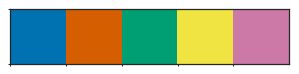

0.8.1


In [7]:
import os
from glob import glob

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.optimize import curve_fit

import pandas as pd
import rpy2.robjects as robj

from sinaplot import sinaplot

%load_ext rpy2.ipython
robj.pandas2ri.activate()

%matplotlib inline
sns.set(font='Arial')
plt.rcParams['svg.fonttype'] = 'none'
style = sns.axes_style('white')
style.update(sns.axes_style('ticks'))
style['xtick.major.size'] = 2
style['ytick.major.size'] = 2
sns.set(font_scale=2, style=style)
pal = sns.color_palette(['#0072b2', '#d55e00', '#009e73', '#f0e442', '#cc79a7'])
sns.set_palette(pal)
sns.palplot(pal)
plt.show()

print(sns.__version__)

[ 386.66260257  137.22756924   29.1278305 ]


NameError: name 'x' is not defined

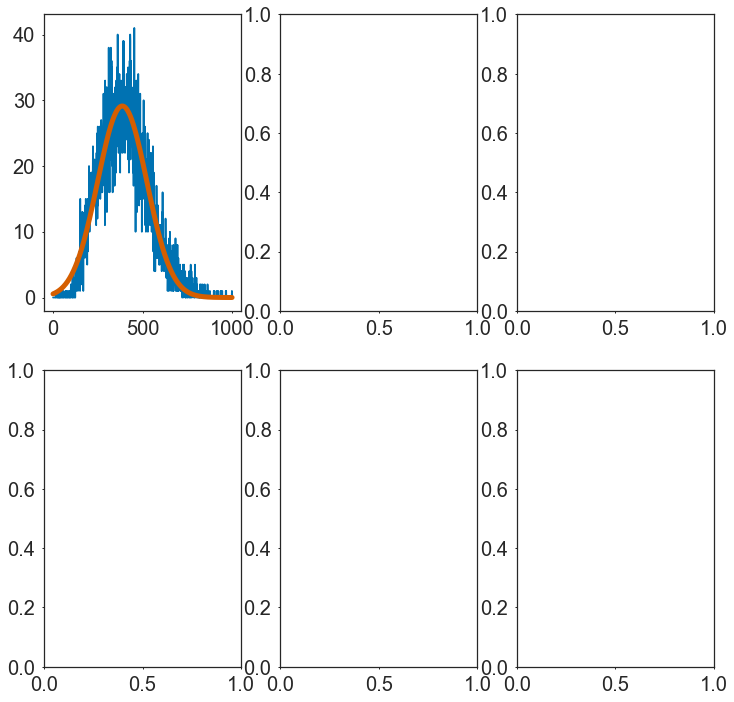

In [4]:
def gauss(x, mu, sigma, A):
    return A * np.exp(-(x - mu) ** 2 / 2 / sigma ** 2)


fig, axes = plt.subplots(figsize=(12, 12), nrows=2, ncols=3)
frag_dist = []
for fn, ax in zip(glob('./salmon_output/*/aux_info/fld'), axes.ravel()):
    y = np.fromfile(fn, dtype=np.int32)
    exp = (450, 50, 35)
    params, _ = curve_fit(gauss, np.arange(len(y)), y, exp)
    print(params)
    ax.plot(y)
    ax.plot(gauss(np.arange(len(y)), *params), lw=5)
    frag_dist.append(x)
plt.show()

In [ ]:
frag_dist[0]

In [5]:
tx2gene = pd.read_csv('./salmon_output/A_Negative/quant.sf',
                      sep='\t',
                      usecols=[0])
tx2gene.columns = ['TXNAME']
tx2gene['GENEID'] = tx2gene.TXNAME.str.split('.', expand=True)[0]
tx2gene.head()

,TXNAME,GENEID
0,AT1G01010.1,AT1G01010
1,AT1G01020.2,AT1G01020
2,AT1G01020.6,AT1G01020
3,AT1G01020.1,AT1G01020
4,AT1G01020.4,AT1G01020


In [6]:
%%R
library(stringr)
library(tximport)
library(edgeR)
sessionInfo()

/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: limma

  warnings.warn(x, RRuntimeWarning)


R version 3.4.1 (2017-06-30)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 16.04.4 LTS

Matrix products: default
BLAS: /home/matthew/anaconda3/envs/ml_python35/lib/R/lib/libRblas.so
LAPACK: /home/matthew/anaconda3/envs/ml_python35/lib/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_GB.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_GB.UTF-8        LC_COLLATE=en_GB.UTF-8    
 [5] LC_MONETARY=en_GB.UTF-8    LC_MESSAGES=en_GB.UTF-8   
 [7] LC_PAPER=en_GB.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_GB.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] tools     stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] edgeR_3.20.7           limma_3.34.6           tximport_1.6.0        
[4] stringr_1.3.0          goseq_1.30.0           geneLenDataBase_1.10.0
[7] BiasedUrn_1.07        

loaded via a namespace (and not attached):
 [1] Rcpp_0

In [7]:
%%R -i tx2gene
files <- Sys.glob('./salmon_output/*/quant.sf')
names(files) <- str_split_fixed(files, "/", 4)[,3]
salmon.gene <- tximport(files,
                        type="salmon",
                        tx2gene=tx2gene)

/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: limma

  warnings.warn(x, RRuntimeWarning)
/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: reading in files with read.delim (install 'readr' package for speed up)

  warnings.warn(x, RRuntimeWarning)
/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 1 
  warnings.warn(x, RRuntimeWarning)
/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 2 
  warnings.warn(x, RRuntimeWarning)
/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 3 
  warnings.warn(x, RRuntimeWarning)
/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntime

In [8]:
%%R
sample_groups <- factor(str_split_fixed(names(files), '_', 2)[,2])
design <- model.matrix(~0 + sample_groups)
rownames(design) <- names(files)
colnames(design) <- levels(sample_groups)
design

           Negative NMM
A_Negative        1   0
A_NMM             0   1
B_Negative        1   0
B_NMM             0   1
C_Negative        1   0
C_NMM             0   1
attr(,"assign")
[1] 1 1
attr(,"contrasts")
attr(,"contrasts")$sample_groups
[1] "contr.treatment"



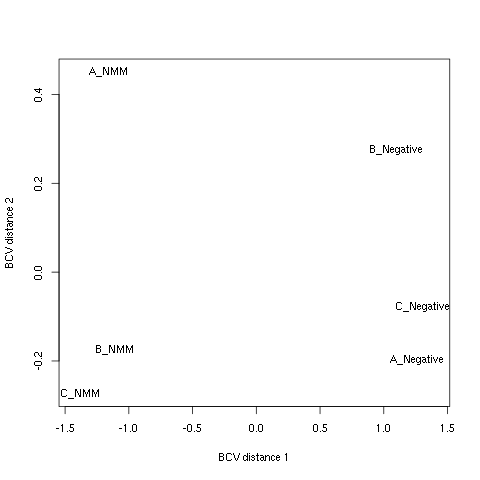

In [9]:
%%R
counts = salmon.gene$counts
len = salmon.gene$length
normMat <- len/exp(rowMeans(log(len)))
o <- log(calcNormFactors(counts/normMat)) + log(colSums(counts/normMat))
y <- DGEList(counts)
y$offset <- t(t(log(normMat)) + o)
keep <- rowSums(cpm(y) > 1) >= 2
#y <- y[keep, , keep.lib.sizes=FALSE]
plotMDS(y, method='bcv', top=200)

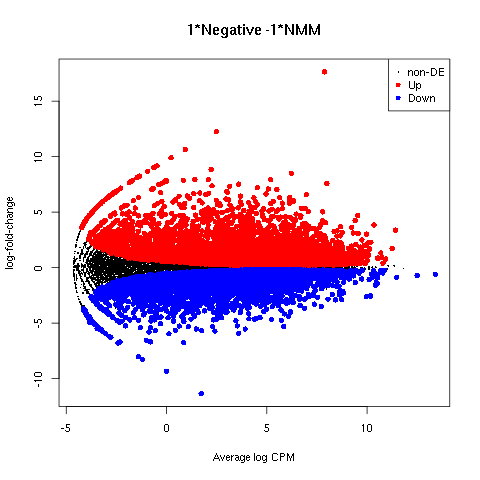

In [10]:
%%R
y <- estimateDisp(y, design=design)
fit <- glmFit(y, design)
nmm_v_cntrl <- glmLRT(fit,
                      contrast=makeContrasts('Negative - NMM', levels=design))
plotMD(nmm_v_cntrl)

In [11]:
%%R -o nmm_v_cntrl_res
nmm_v_cntrl_res <- as.data.frame(topTags(nmm_v_cntrl, n=Inf, adjust.method='BH'))
norm_counts <- as.data.frame(cpm(y, normalized.lib.sizes = TRUE, log=TRUE))
nmm_v_cntrl_res <- merge(nmm_v_cntrl_res,
                         norm_counts,
                         by=0,
                         all.x=TRUE,
                         all.y = FALSE)
rownames(nmm_v_cntrl_res) <- nmm_v_cntrl_res$Row.names
nmm_v_cntrl_res <- nmm_v_cntrl_res[, 2:ncol(nmm_v_cntrl_res)]

In [12]:
nmm_v_cntrl_res.sort_values(by=['logFC', 'FDR'], ascending=[True, True]).head(n=10)

,logFC,logCPM,LR,PValue,FDR,A_Negative,A_NMM,B_Negative,B_NMM,C_Negative,C_NMM
AT1G07130,-11.357657,1.723502,26.009442,3.397517e-07,1.686074e-06,-7.638231,3.590038,-7.638231,-7.638231,-7.638231,3.128226
AT1G23052,-9.337117,-0.002373,26.900241,2.142322e-07,1.081471e-06,-7.638231,1.256783,-7.638231,1.468117,-7.638231,-7.638231
AT1G49100,-8.270828,-1.200229,82.705325,9.524431e-20,1.019947e-18,-7.638231,-0.877930,-7.638231,-0.449032,-7.638231,0.263887
AT3G46370,-8.010568,-1.404484,99.055547,2.455179e-23,3.061560e-22,-7.638231,-0.626322,-7.638231,-0.739591,-7.638231,-0.252876
AT1G33840,-6.797251,-2.419568,51.671522,6.560751e-13,4.914651e-12,-7.638231,-1.864683,-7.638231,-1.727549,-7.638231,-1.685507
AT2G28270,-6.760687,0.856393,295.877219,2.606195e-66,1.180265e-64,-4.446103,1.732369,-5.347822,1.642905,-5.252772,2.109382
AT1G38065,-6.690187,-2.317006,17.653073,2.650867e-05,1.078645e-04,-7.638231,-2.091898,-7.638231,-0.821251,-7.638231,-7.638231
AT3G18450,-6.689911,-0.800440,143.323930,4.993506e-33,8.790981e-32,-7.638231,0.142755,-5.347822,-0.088661,-7.638231,0.263887
AT5G59270,-6.549866,-0.999998,90.076265,2.291543e-21,2.624284e-20,-7.638231,-0.412147,-5.347822,-0.391704,-7.638231,0.451593
AT5G10570,-6.299018,-2.797976,36.272391,1.715773e-09,1.028743e-08,-7.638231,-2.100904,-7.638231,-2.448616,-7.638231,-2.136230


In [13]:
nmm_melt = pd.melt(
    nmm_v_cntrl_res.reset_index(),
    id_vars=['index', 'FDR'],
    value_vars=['A_Negative', 'B_Negative', 'C_Negative', 'A_NMM', 'B_NMM', 'C_NMM'],
    var_name='condition',
    value_name='expression')
nmm_melt['condition'] = nmm_melt.condition.str[2:]
nmm_melt['condition'] = nmm_melt['condition'].astype('category')
nmm_melt.condition.cat.categories = ['Negative', 'NMM']
nmm_melt = nmm_melt.sort_values(by='index')
nmm_melt.head()

,index,FDR,condition,expression
0,AT1G01010,1.689300e-19,NMM,6.059700
65666,AT1G01010,1.689300e-19,NMM,5.919644
164165,AT1G01010,1.689300e-19,Negative,5.312551
131332,AT1G01010,1.689300e-19,Negative,5.237143
98499,AT1G01010,1.689300e-19,Negative,5.199620


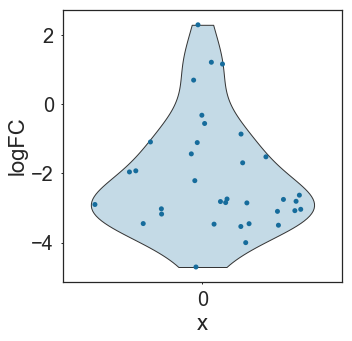

In [90]:
rsl4_gtl1_reg_genes = pd.read_table('rsl4_gtl1_reg_genes.txt',
                                    sep='\s+',
                                    usecols=[0],
                                    header=None,
                                    names=['gene'])
rsl4_gtl1_reg_genes = rsl4_gtl1_reg_genes.gene.str.upper().values

fig, ax = plt.subplots(figsize=(5, 5))
data=nmm_v_cntrl_res[nmm_v_cntrl_res.index.isin(rsl4_gtl1_reg_genes)].copy()
data['x'] = 0
sinaplot(x='x',
         y='logFC',
         random_state=109,
         cut=0,
         data=data)
plt.show()

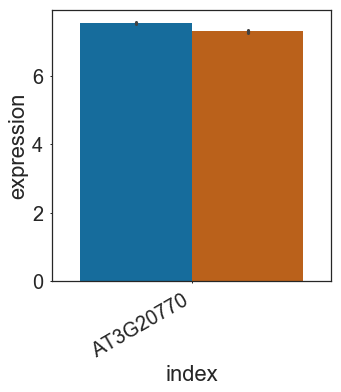

In [38]:
csa = {
    'AT3G20770'
}

fig, ax = plt.subplots(figsize=(5, 5))
data = nmm_melt[nmm_melt['index'].isin(csa)]
sns.barplot(x='index', y='expression', hue='condition', data=data, ci='sd', hue_order=['NMM', 'Negative'])
ax.legend_.remove()
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
y = data.expression.max() + 0.5
for x, fdr in enumerate(data[['index', 'FDR']].drop_duplicates().FDR):
    if fdr < 0.05:
        ax.annotate(xy=(x - 0.1, y), s='*')
#ax.set_ylim(0, 6)
plt.show()

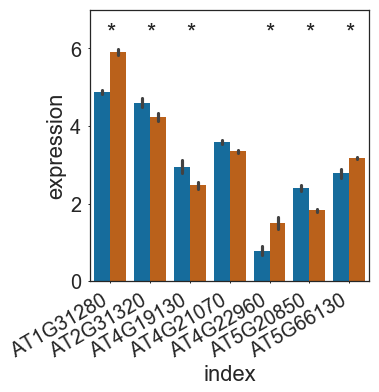

In [11]:
dna_damage_responsive = {
    'AT1G31280',
    'AT4G21070',
    'AT4G22960',
    'AT2G31320',
    'AT5G66130',
    'AT5G20850',
    'AT4G19130',
}


fig, ax = plt.subplots(figsize=(5, 5))
data = nmm_melt[nmm_melt['index'].isin(dna_damage_responsive)]
sns.barplot(x='index', y='expression', hue='condition', data=data, ci='sd')
ax.legend_.remove()
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
y = data.expression.max() + 0.25
for x, fdr in enumerate(data[['index', 'FDR']].drop_duplicates().FDR):
    if fdr < 0.05:
        ax.annotate(xy=(x - 0.1, y), s='*')
ax.set_ylim(0, 7)
plt.show()

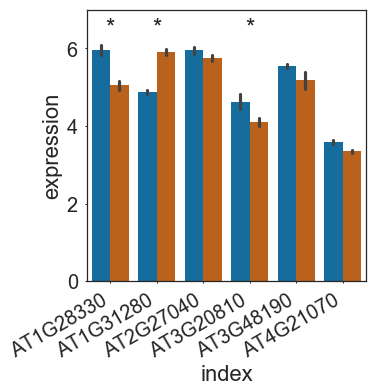

In [12]:
dna_damage_transposon = {
    'AT3G48190',
    'AT1G31280',
    'AT4G21070',
    'AT1G28330',
    'AT3G20810',
    'AT2G27040',
}

fig, ax = plt.subplots(figsize=(5, 5))
data = nmm_melt[nmm_melt['index'].isin(dna_damage_transposon)]
sns.barplot(x='index', y='expression', hue='condition', data=data, ci='sd')
ax.legend_.remove()
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
y = data.expression.max() + 0.25
for x, fdr in enumerate(data[['index', 'FDR']].drop_duplicates().FDR):
    if fdr < 0.05:
        ax.annotate(xy=(x - 0.1, y), s='*')
ax.set_ylim(0, 7)
plt.show()

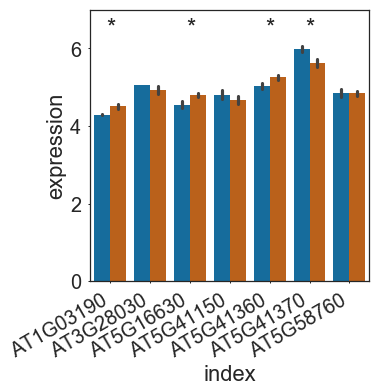

In [13]:
ner = {
    'AT5G41370',
    'AT5G41360',
    'AT5G16630',
    'AT1G03190',
    'AT5G58760',
    'AT5G41150',
    'AT3G28030'
}

fig, ax = plt.subplots(figsize=(5, 5))
data = nmm_melt[nmm_melt['index'].isin(ner)]
sns.barplot(x='index', y='expression', hue='condition', data=data, ci='sd')
ax.legend_.remove()
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
y = data.expression.max() + 0.25
for x, fdr in enumerate(data[['index', 'FDR']].drop_duplicates().FDR):
    if fdr < 0.05:
        ax.annotate(xy=(x - 0.1, y), s='*')
ax.set_ylim(0, 7)
plt.show()

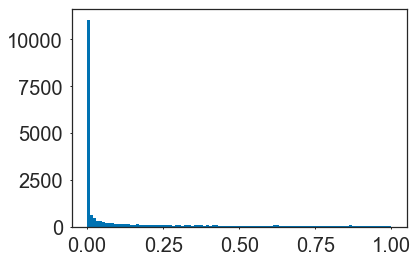

In [14]:
plt.hist(nmm_v_cntrl_res.PValue, bins=100)
plt.show()

In [9]:
nmm_v_cntrl_res.to_csv(
    './nmm_rnaseq_differential_expression_05022018.tsv', sep='\t')

In [17]:
nmm_v_cntrl_res.head()

,logFC,logCPM,LR,PValue,FDR,A_Negative,A_NMM,B_Negative,B_NMM,C_Negative,C_NMM
AT1G01010,0.848345,5.679371,86.897764,1.142785e-20,7.723917e-20,6.061120,5.201267,6.034207,5.238690,5.921129,5.313969
AT1G01020,-0.112609,4.284573,1.324880,2.497181e-01,3.226948e-01,4.124961,4.582637,4.191397,4.386639,4.207503,4.132619
AT1G01030,-0.148465,1.414800,0.749500,3.866346e-01,4.668409e-01,1.078083,1.697544,1.392574,1.630670,1.186892,1.211171
AT1G01040,0.170917,5.911781,4.577984,3.238530e-02,5.303067e-02,5.791820,5.888296,6.026004,5.919526,5.944691,5.884326
AT1G01050,-0.462401,6.045595,33.003445,9.199573e-09,3.281001e-08,5.646266,6.270310,5.695635,6.362601,5.786667,6.313878


In [55]:
nmm_v_cntrl_res['downreg'] = ((nmm_v_cntrl_res.FDR < 0.05) &
                              (nmm_v_cntrl_res.logFC < -1)).astype(int)
downreg = pd.Series(nmm_v_cntrl_res.downreg)
downreg.head()

AT1G01010    0
AT1G01020    0
AT1G01030    0
AT1G01040    0
AT1G01050    0
Name: downreg, dtype: int64

In [56]:
gene_lengths = pd.read_table(
    './salmon_output/A_Negative/quant.sf',
    usecols=[0, 1])
gene_lengths['Name'] = gene_lengths.Name.str.split('.', expand=True)[0]
gene_lengths = gene_lengths.groupby('Name').median()['Length']
gene_lengths = gene_lengths[downreg.index].values

In [3]:
%%R
library(goseq)
sessionInfo()

/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: BiasedUrn

  warnings.warn(x, RRuntimeWarning)
/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: geneLenDataBase

  warnings.warn(x, RRuntimeWarning)
/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 

  warnings.warn(x, RRuntimeWarning)


R version 3.4.1 (2017-06-30)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 16.04.4 LTS

Matrix products: default
BLAS: /home/matthew/anaconda3/envs/ml_python35/lib/R/lib/libRblas.so
LAPACK: /home/matthew/anaconda3/envs/ml_python35/lib/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_GB.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_GB.UTF-8        LC_COLLATE=en_GB.UTF-8    
 [5] LC_MONETARY=en_GB.UTF-8    LC_MESSAGES=en_GB.UTF-8   
 [7] LC_PAPER=en_GB.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_GB.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] tools     stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] goseq_1.30.0           geneLenDataBase_1.10.0 BiasedUrn_1.07        

loaded via a namespace (and not attached):
 [1] Rcpp_0.12.15               compiler_3.4.1            
 [3] GenomeInfoDb_1.14.0        XVector_0.18.0      

          DEgenes bias.data        pwf
AT1G01010       0    1688.0 0.08862075
AT1G01020       0    1317.5 0.09299110
AT1G01030       0    1870.5 0.08532494
AT1G01040       0    6076.5 0.02966370
AT1G01050       0     902.0 0.09538307
AT1G01060       0    2715.0 0.06771559


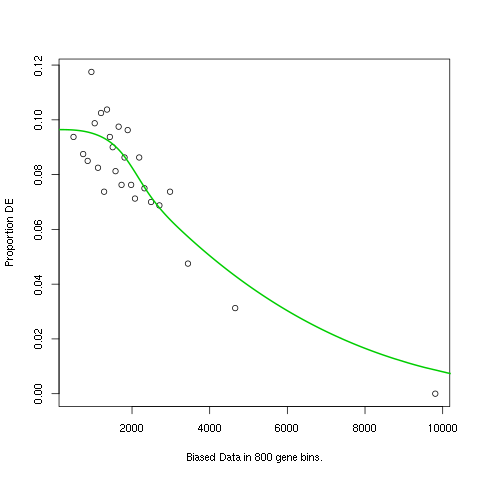

In [57]:
%%R -i downreg,gene_lengths
pwf <- nullp(downreg, bias.data=gene_lengths)
head(pwf)

In [58]:
%%bash
source activate cgat_python2
cp ../tair10_g4_goterms/ATH_GO_GOSLIM.txt .
awk -v FS='\t' -v OFS='\t' '{print $6, $4, $5}' ATH_GO_GOSLIM.txt | \
  sort -k1,1 | uniq > go_terms.txt

sort -k4,4 /home/matthew/Documents/genomes/tair10/gff/araport11_genes.bed > genes.bed
cut -d $'\t' -f1,6 ATH_GO_GOSLIM.txt | sort -k1,1 | grep -P '^AT\dG\d{5}' | uniq > go_genes.txt

head go_genes.txt

AT1G01010	GO:0003677
AT1G01010	GO:0003700
AT1G01010	GO:0005634
AT1G01010	GO:0006351
AT1G01010	GO:0006355
AT1G01010	GO:0007275
AT1G01010	GO:0016021
AT1G01020	GO:0003674
AT1G01020	GO:0005739
AT1G01020	GO:0005783


In [63]:
%%R
go_map <- read.table('./go_genes.txt',
                     sep='\t',
                     col.names=c('ensembl_gene_id', 'go_id'))
go_res <- goseq(pwf, gene2cat=go_map)
head(go_res)

       category over_represented_pvalue under_represented_pvalue numDEInCat
4764 GO:0047134            1.407178e-55                        1         74
1030 GO:0005576            5.617225e-55                        1        303
5329 GO:0055114            1.493142e-35                        1        227
3484 GO:0020037            1.367551e-24                        1         79
1011 GO:0005506            6.827186e-17                        1         63
3454 GO:0019825            1.194526e-16                        1         49
     numInCat                                 term ontology
4764      109 protein-disulfide reductase activity       MF
1030     1433                 extracellular region       CC
5329     1151          oxidation-reduction process       BP
3484      259                         heme binding       MF
1011      238                     iron ion binding       MF
3454      157                       oxygen binding       MF
